In [1]:
%matplotlib inline
import boto3
import botocore
import os.path
import xarray as xr
import datetime

import numpy as np
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
import pickle
from matplotlib import animation, pyplot as plt
from pathlib import Path
import calendar
import os

In [2]:
# Specify your longitude and latitude range
lats = slice(25, 0)
lons = slice(70, 80)

# Initialize a list to store the data
data_list = []

# Iterate over the years and months
start_date = pd.to_datetime('1979-01-01')
end_date = pd.to_datetime('2023-5-31')

curr_date = start_date
while curr_date <= end_date:
    year = curr_date.year
    month = curr_date.month
    
    # Get the number of days in the month
    _, num_days = calendar.monthrange(year, month)
    
    # Construct the file path
    file_path = f'/home/jovyan/shared/data_sst/{year}{month:02d}_sea_surface_temperature.nc'
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f'File not found: {file_path}. Skipping this month.')
        curr_date += relativedelta(months=1)
        continue
    
    # Open the dataset
    ds = xr.open_dataset(file_path)
    
    # Select the time points
    time_points = pd.date_range(start=f'{year}-{month:02d}-01T09:00:00', end=f'{year}-{month:02d}-{num_days}T09:00:00', freq='D')
    ds_selected_time = ds.sel(time0=time_points, method='nearest')
    
    # Select the longitude and latitude
    ds_selected = ds_selected_time.sel(lon=lons, lat=lats)
    
    # Get the sea_surface_temperature values
    sst_data = ds_selected['sea_surface_temperature'].values
    sst_data = np.expand_dims(sst_data, axis=-1)
    
    # Append the data to the list
    data_list.append(sst_data)
    
    # Move to the next month
    curr_date += relativedelta(months=1)
    
    # Print a message
    print(f'Successfully processed data for: {year}-{month:02d}')

# Concatenate all the data
sst_data = np.concatenate(data_list, axis=0)

print(sst_data.shape)

Successfully processed data for: 1979-01
Successfully processed data for: 1979-02
Successfully processed data for: 1979-03
Successfully processed data for: 1979-04
Successfully processed data for: 1979-05
Successfully processed data for: 1979-06
Successfully processed data for: 1979-07
Successfully processed data for: 1979-08
Successfully processed data for: 1979-09
Successfully processed data for: 1979-10
Successfully processed data for: 1979-11
Successfully processed data for: 1979-12
Successfully processed data for: 1980-01
Successfully processed data for: 1980-02
Successfully processed data for: 1980-03
Successfully processed data for: 1980-04
Successfully processed data for: 1980-05
Successfully processed data for: 1980-06
Successfully processed data for: 1980-07
Successfully processed data for: 1980-08
Successfully processed data for: 1980-09
Successfully processed data for: 1980-10
Successfully processed data for: 1980-11
Successfully processed data for: 1980-12
Successfully pro

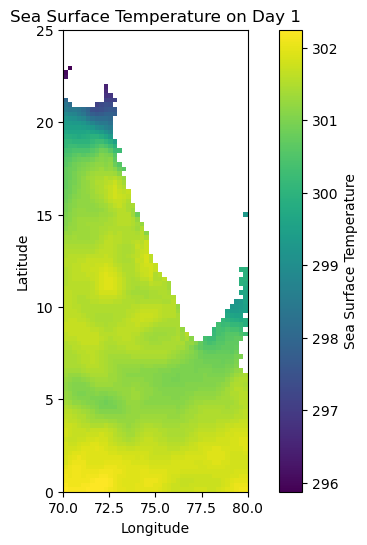

In [6]:
# Choose one day of data
day_index = 0  # choose the day
day_data = sst_data[day_index]

# Remove the last dimension
day_data = np.squeeze(day_data)

# Flip the data along the first axis
day_data = np.flipud(day_data)

# Get the lat and lon values
lat_values = ds_selected.lat.values
lon_values = ds_selected.lon.values

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the data of the day
plt.imshow(day_data, cmap='viridis', origin='lower', extent=[lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()])

# Add a colorbar
plt.colorbar(label='Sea Surface Temperature')

# Set the labels for the x and y axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Sea Surface Temperature on Day {}'.format(day_index+1))

# Show the plot
plt.show()

In [7]:
start_year = 1979
end_year = 2023

# List to store all group labels
all_labels = pd.Series(dtype=int)

# Process each year
for year in range(start_year, end_year + 1):
    # Process each month
    for month in range(1, 13):
        if year == 2023 and month > 5:
            break
        file_name = f"/home/jovyan/shared/SST_Diff/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22, 23 or 24, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23,24])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 3 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

Processing file /home/jovyan/shared/SST_Diff/197901_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197902_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197903_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197904_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197905_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197906_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197907_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197908_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197909_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197910_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197911_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/197912_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/198001_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/198002_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/198003_sst_diff.n

In [8]:
# Convert the index to datetime
all_labels.index = pd.to_datetime(all_labels.index)

# Filter for given year & month
june_2020_labels = all_labels[(all_labels.index.month == 7) & (all_labels.index.year == 2017)]

print(june_2020_labels)

2017-07-01 09:00:00    0
2017-07-02 09:00:00    0
2017-07-03 09:00:00    0
2017-07-04 09:00:00    0
2017-07-05 09:00:00    0
2017-07-06 09:00:00    0
2017-07-07 09:00:00    0
2017-07-08 09:00:00    0
2017-07-09 09:00:00    0
2017-07-10 09:00:00    0
2017-07-11 09:00:00    0
2017-07-12 09:00:00    0
2017-07-13 09:00:00    0
2017-07-14 09:00:00    0
2017-07-15 09:00:00    0
2017-07-16 09:00:00    0
2017-07-17 09:00:00    0
2017-07-18 09:00:00    0
2017-07-19 09:00:00    0
2017-07-20 09:00:00    0
2017-07-21 09:00:00    1
2017-07-22 09:00:00    1
2017-07-23 09:00:00    0
2017-07-24 09:00:00    0
2017-07-25 09:00:00    0
2017-07-26 09:00:00    0
2017-07-27 09:00:00    0
2017-07-28 09:00:00    0
2017-07-29 09:00:00    0
2017-07-30 09:00:00    0
2017-07-31 09:00:00    0
dtype: int64


In [9]:
num_ones = all_labels.sum()
print(f"Number of 1s in all_labels: {num_ones}")

Number of 1s in all_labels: 557


In [10]:
sst_data = np.squeeze(sst_data)

# Flatten the spatial dimensions of the data
sst_data = sst_data.reshape((sst_data.shape[0], -1))

sst_data = np.nan_to_num(sst_data, nan=0.0)

In [11]:
# Convert all_labels to a 1D numpy array
all_labels_reshaped = all_labels.values.ravel()

In [12]:
print("Shape of sst_data_reshaped: ", sst_data.shape)
print("Shape of all_labels_reshaped: ", all_labels_reshaped.shape)

Shape of sst_data_reshaped:  (15958, 4141)
Shape of all_labels_reshaped:  (15958,)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(sst_data, all_labels_reshaped, test_size=0.5, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) 
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation function for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary crossentropy as loss function for binary classification

# Fit model
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

2023-07-11 15:47:18.325996: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 15:47:18.493625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 15:47:18.494757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 15:47:19.611223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


250/250 [==============================] - 79s 313ms/step - loss: nan - accuracy: 0.9662
Accuracy: 0.9661611914634705


In [14]:
sst_data.shape

(15958, 4141)

In [15]:
day_index = 15
day_data = sst_data[day_index].reshape(1, -1, 1)
prediction = model.predict(day_data)
predicted_class = 1 if prediction > 0.5 else 0
print("Predicted class for day {}: {}".format(day_index, predicted_class))

1/1 [==============================] - 0s 286ms/step
Predicted class for day 15: 0


In [16]:
model.save('LSTM_197901-202305.h5')

In [ ]:
# time model_prediction true_label (for all times)

In [21]:
all_labels.shape

(15958,)

In [23]:
def count_days(start_date, end_date, excluded_months):
    curr_date = start_date
    total_days = 0
    while curr_date <= end_date:
        year_month = curr_date.strftime('%Y%m')
        if year_month not in excluded_months:
            _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
            total_days += num_days
        curr_date += relativedelta(months=1)
    return total_days

start_date = pd.to_datetime('1979-01-01')
end_date = pd.to_datetime('2023-5-31')
excluded_months = ['198304', '198802', '199209', '199702', '200111', '200604', '201102', '201506', '202002']
total_days = count_days(start_date, end_date, excluded_months)

print(total_days)

15958


In [25]:
# Start date
start_date = pd.to_datetime('1979-01-01')

# Initialize an empty list to store the rows of the DataFrame
data = []

# Initialize the current index of sst_data and all_labels_reshaped
curr_index = 0

# Iterate over the dates
curr_date = start_date
while curr_date <= end_date:
    year_month = curr_date.strftime('%Y%m')
    if year_month in excluded_months:
        curr_date += relativedelta(months=1)
        continue
    _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
    for _ in range(num_days):
        # Get the actual value
        actual_val = all_labels_reshaped[curr_index]

        # Get the prediction
        day_data = sst_data[curr_index].reshape(1, -1, 1)
        prediction = model.predict(day_data)
        predicted_val = 1 if prediction > 0.5 else 0

        # Append the data to the list
        data.append({'time': curr_date, 'actual_val': actual_val, 'predicted_val': predicted_val})

        # Increase the current index and the current date
        curr_index += 1
        curr_date += pd.DateOffset(days=1)
    curr_date += relativedelta(months=1)
    
# Create the DataFrame
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

1/1 [==============================] - 0s 200ms/step
           time  actual_val  predicted_val
0    1979-01-01           0              0
1    1979-01-02           0              0
2    1979-01-03           0              0
3    1979-01-04           0              0
4    1979-01-05           0              0
...         ...         ...            ...
8100 2023-05-27           0              0
8101 2023-05-28           0              0
8102 2023-05-29           1              0
8103 2023-05-30           0              0
8104 2023-05-31           0              0

[8105 rows x 3 columns]


In [27]:
# df.to_csv('predictions.csv', index=False)

In [39]:
# diff_count = df[(df['actual_val'] == 1) & (df['predicted_val'] == 0)].shape[0]
# diff_count
df[df['predicted_val']==1]

0

In [29]:
total_rows = df.shape[0]

diff_percentage = discrepancy_count / total_rows * 100
diff_percentage

1.9000616903146206